<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/QREC_SOMBO_Troch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install botorch

In [160]:
import torch
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.monte_carlo import qExpectedImprovement
# from botorch.acquisition import qExpectedConstrainedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np


import scipy as sp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import differential_evolution
from scipy.optimize import minimize, NonlinearConstraint

import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import solve_ivp
from scipy import integrate
import warnings

In [161]:
import os
from typing import Optional

import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [163]:
# smb model
# # tips:
    # - the Error: "IndexError: index 10 is out of bounds for axis 0 with size 9"
    # may be due to a miss-match in size between the initial conditons and c, q in the ode func.
# IMPORTING LIBRARIES
###########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# Loading the Plotting Libraries
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# from PIL import Image
from scipy import integrate
# import plotly.graph_objects as go
import pandas as pd
import json
import os
import time
###########################################
# IMPORTING MY OWN FUNCTIONS
###########################################
# from post_pre_processing_funcs import

# INPUTS
#######################################################

# UNITS:
# All units must conform to:
# Time - s
# Lengths - cm^2
# Volumes - cm^3
# Masses - g
# Concentrations - g
# Volumetric flowrates - cm^3/s


def SMB(SMB_inputs):
    iso_type, Names, color, num_comp, nx_per_col, e, Pe_all, Bm, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets = SMB_inputs[0:]

    ###################### (CALCUALTED) SECONDARY INPUTS #########################

    # Column Dimensions:
    ################################################################
    F = (1-e)/e     # Phase ratio
    t=0
    t_sets = 0
    Ncol_num = np.sum(zone_config) # Total number of columns
    L_total = L*Ncol_num # Total Lenght of all columns
    A_col = np.pi*0.25*d_col**2 # cm^2
    V_col = A_col * L # cm^3
    V_col_total = Ncol_num * V_col # cm^3
    A_in = np.pi * (d_in/2)**2 # cm^2
    alpha = A_in / A_col



    # Time Specs:
    ################################################################

    t_index = t_index_min*60 # s #

    # Notes:
    # - Cyclic Steady state typically happens only after 10 cycles (ref: https://doi.org/10.1205/026387603765444500)
    # - The system is not currently designed to account for periods of no external flow

    n_1_cycle = t_index * Ncol_num  # s How long a single cycle takes

    total_cycle_time = n_1_cycle*n_num_cycles # s

    tend = total_cycle_time # s # Final time point in ODE solver

    tend_min = tend/60

    t_span = (0, tend) # +dt)  # from t=0 to t=n

    num_of_injections = int(np.round(tend/t_index)) # number of switching periods

    # 't_start_inject_all' is a vecoter containing the times when port swithes occur for each port
    # Rows --> Different Ports
    # Cols --> Different time points
    t_start_inject_all = [[] for _ in range(Ncol_num)]  # One list for each node (including the main list)

    # Calculate start times for injections
    for k in range(num_of_injections):
        t_start_inject = k * t_index
        t_start_inject_all[0].append(t_start_inject)  # Main list
        for node in range(1, Ncol_num):
            t_start_inject_all[node].append(t_start_inject + node * 0)  # all rows in t_start_inject_all are identical

    t_schedule = t_start_inject_all[0]

    # REQUIRED FUNCTIONS:
    ################################################################

    # 1.
    # Func to Generate Indices for the columns
    # def generate_repeated_numbers(n, m):
    #     result = []
    #     n = int(n)
    #     m = int(m)
    #     for i in range(m):
    #         result.extend([i] * n)
    #     return result

    # 3.
    # Func to divide the column into nodes

    # DOES NOT INCLUDE THE C0 NODE (BY DEFAULT)
    def set_x(L, Ncol_num,nx_col,dx):
        if nx_col == None:
            x = np.arange(0, L+dx, dx)
            nnx = len(x)
            nnx_col = int(np.round(nnx/Ncol_num))
            nx_BC = Ncol_num - 1 # Number of Nodes (mixing points/boundary conditions) in between columns

            # Indecies belonging to the mixing points between columns are stored in 'start'
            # These can be thought of as the locations of the nx_BC nodes.
            return x, dx, nnx_col,  nnx, nx_BC

        elif dx == None:
            nx = Ncol_num * nx_col
            nx_BC = Ncol_num - 1 # Number of Nodes in between columns
            x = np.linspace(0,L_total,nx)
            ddx = x[1] - x[0]

            # Indecies belonging to the mixing points between columns are stored in 'start'
            # These can be thought of as the locations of the nx_BC nodes.

            return x, ddx, nx_col, nx, nx_BC

    # 4. A func that:
    # (i) Calcualtes the internal flowrates given the external OR (ii) Visa-versa
    def set_flowrate_values(set_Q_int, set_Q_ext, Q_rec):
        if set_Q_ext is None and Q_rec is None:  # Chosen to specify internal/zone flowrates
            Q_I = set_Q_int[0]
            Q_II = set_Q_int[1]
            Q_III = set_Q_int[2]
            Q_IV = set_Q_int[3]

            QX = -(Q_I - Q_II)
            QF = Q_III - Q_II
            QR = -(Q_III - Q_IV)
            QD = -(QF + QX + QR) # OR: Q_I - Q_IV

            Q_ext = np.array([QF, QR, QD, QX]) # cm^3/s

            return Q_ext

        elif set_Q_int is None and Q_rec is not None:  # Chosen to specify external flowrates
            QF = set_Q_ext[0]
            QR = set_Q_ext[1]
            QD = set_Q_ext[2]
            QX = set_Q_ext[3]

            Q_I = Q_rec  # m^3/s
            Q_III = (QX + QF) + Q_I
            Q_IV = (QD - QX) + Q_I  # Fixed Q_II to Q_I as the variable was not defined yet
            Q_II = (QR - QX) + Q_IV
            Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
            return Q_internal


    # 5. Function to Build Port Schedules:

    # This is done in two functions: (i) repeat_array and (ii) build_matrix_from_vector
    # (i) repeat_array
    # Summary: Creates the schedule for the 1st port, port 0, only. This is the port boadering Z2 & Z3 and always starts as a Feed port at t=0
    # (i) build_matrix_from_vector
    # Summary: Takes the output from "repeat_array" and creates schedules for all other ports.
    # The "trick" is that the states of each of the, n, ports at t=0, is equal to the first, n, states of port 0.
    # Once we know the states for each port at t=0, we form a loop that adds the next state.

    # 5.1
    def position_maker(schedule_quantity_name, F, R, D, X, Z_config):

        """

        Function that initializes the starting schedueles for a given quantitiy at all positions

        F, R, D and X are the values of the quantiity at the respective feed ports

        """
        # Initialize:
        X_j = np.zeros(Ncol_num)


        # We set each port in the appropriate position, depending on the nuber of col b/n Zones:
        # By default, Position i = 0 (entrance to col,0) is reserved for the feed node.

        # Initialize Positions:
        # Q_position is a vector whose len is = number of mixing points (ports) b/n columns

        X_j[0] = F        # FEED
        X_j[Z_config[2]] = R     # RAFFINATE
        X_j[Z_config[2] + Z_config[3]] = D    # DESORBENT
        X_j[Z_config[2] + Z_config[3]+  Z_config[0]] = X   # EXTRACT

        return X_j

    # 5.2
    def repeat_array(vector, start_time_num):
        # vector = the states of all ports at t=0, vector[0] = is always the Feed port
        # start_time_num = The number of times the state changes == num of port switches == num_injections
        repeated_array = np.tile(vector, (start_time_num // len(vector) + 1))
        return repeated_array[:start_time_num]

    def initial_u_col(Zconfig, Qint):
        """
        Fun that returns the the inital state at t=0 of the volumetric
        flows in all the columns.

        """
        # First row is for col0, which is the feed to zone 3
        Zconfig_roll = np.roll(Zconfig, -2)
        Qint_roll = np.roll(Qint, -2)

        # print(Qint)
        X = np.array([])

        for i in range(len(Qint_roll)):
            X_add = np.ones(Zconfig_roll[i])*Qint_roll[i]
            # print('X_add:\n', X_add)

            X = np.append(X, X_add)
        # X = np.concatenate(X)
        # print('X:\n', X)
        return X


    def build_matrix_from_vector(vector, t_schedule):
        """
        Fun that returns the schedeule given the inital state at t=0
        vector: inital state of given quantity at t=0 at all nodes
        t_schedule: times at which port changes happen

        """
        # vector = the states of all ports at t=0, vector[0] = is always the Feed port
        start_time_num = int(len(t_schedule))
        vector = np.array(vector)  # Convert the vector to a NumPy array
        n = len(vector) # number of ports/columns

        # Initialize the matrix for repeated elements, ''ALL''
        ALL = np.zeros((n, start_time_num), dtype=vector.dtype)  # Shape is (n, start_time_num)

        for i in range(start_time_num):
            # print('i:',i)
            ALL[:, i] = np.roll(vector, i)
        return ALL



    # # Uncomment as necessary depending on specification of either:
    # # (1) Internal OR (2) External flowrates :
    # # (1)
    # Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
    Q_external = set_flowrate_values(Q_internal, None, None) # Order: QF, QR, QD, QX
    QF, QR, QD, QX = Q_external[0], Q_external[1], Q_external[2], Q_external[3]
    # print('Q_external:', Q_external)

    # (2)
    # QX, QF, QR = -0.277, 0.315, -0.231  # cm^3/s
    # QD = - (QF + QX + QR)
    # Q_external = np.array([QF, QR, QD, QX])
    # Q_rec = 33.69 # cm^3/s
    # Q_internal = set_flowrate_values(None, Q_external, Q_rec) # Order: QF, QR, QD, Q

    ################################################################################################


    # Make concentration schedules for each component

    Cj_pulse_all = [[] for _ in range(num_comp)]
    for i in range(num_comp):
        Cj_position = []
        Cj_position = position_maker('Feed Conc Schedule:', parameter_sets[i]['C_feed'], 0, 0, 0, zone_config)
        Cj_pulse = build_matrix_from_vector(Cj_position,  t_schedule)
        Cj_pulse_all[i] = Cj_pulse


    Q_position = position_maker('Vol Flow Schedule:', Q_external[0], Q_external[1], Q_external[2], Q_external[3], zone_config)
    Q_pulse_all = build_matrix_from_vector(Q_position,  t_schedule)

    # Spacial Discretization:
    # Info:
    # nx --> Total Number of Nodes (EXCLUDING mixing points b/n nodes)
    # nx_col --> Number of nodes in 1 column
    # nx_BC --> Number of mixing points b/n nodes
    x, dx, nx_col, nx, nx_BC = set_x(L=L_total, Ncol_num = Ncol_num, nx_col = nx_per_col, dx = None)
    start = [i*nx_col for i in range(0,Ncol_num)] # Locations of the BC indecies
    u_col_at_t0 = initial_u_col(zone_config, Q_internal)
    Q_col_all = build_matrix_from_vector(u_col_at_t0, t_schedule)


    # DISPLAYING INPUT INFORMATION:
    # print('---------------------------------------------------')
    # print('Number of Components:', num_comp)
    # print('---------------------------------------------------')
    # print('\nTime Specs:\n')
    # print('---------------------------------------------------')
    # print('Number of Cycles:', n_num_cycles)
    # print('Time Per Cycle:', n_1_cycle/60, "min")
    # print('Simulation Time:', tend_min, 'min')
    # print('Index Time:', t_index, 's OR', t_index/60, 'min' )
    # print('Number of Port Switches:', num_of_injections)
    # print('Injections happen at t(s) = :', t_schedule, 'seconds')
    # print('---------------------------------------------------')
    # print('\nColumn Specs:\n')
    # print('---------------------------------------------------')
    # print('Configuration:', zone_config, '[Z1,Z2,Z3,Z4]')
    # print(f"Number of Columns: {Ncol_num}")
    # print('Column Length:', L, 'cm')
    # print('Column Diameter:', d_col, 'cm')
    # print('Column Volume:', V_col, 'cm^3')
    # print("alpha:", alpha, '(alpha = A_in / A_col)')
    # print("Nodes per Column:",nx_col)
    # print("Boundary Nodes locations,x[i], i =", start)
    # print("Total Number of Nodes (nx):",nx)
    # print('---------------------------------------------------')
    # print('\nFlowrate Specs:\n')
    # print('---------------------------------------------------')
    # print("External Flowrates =", Q_external, '[F,R,D,X] ml/min')
    # print("Ineternal Flowrates =", Q_internal, 'ml/min')
    # print('---------------------------------------------------')
    # print('\nPort Schedules:')
    # for i in range(num_comp):
    #     print(f"Concentration Schedule:\nShape:\n {Names[i]}:\n",np.shape(Cj_pulse_all[i]),'\n', Cj_pulse_all[i], "\n")
    # print("Injection Flowrate Schedule:\nShape:",np.shape(Q_pulse_all),'\n', Q_pulse_all, "\n")
    # print("Respective Column Flowrate Schedule:\nShape:",np.shape(Q_col_all),'\n', Q_col_all, "\n")



    # ###########################################################################################

    # Isotherm Models:


    ###########################################################################################

    # 1. LINEAR
    def iso_lin(theta_lin, c):
        # params: [HA, HB]
        H = theta_lin
        q_star = H*c

        return q_star # [qA, qB, ...]

    # 2.  LANGMUIR

    # 2.1 Independent Langmuir
    def iso_langmuir(theta_lang, c, comp_idx): # already for specific comp
        H = theta_lang
        q_star = H*c/(1 + H*c)
        #q_star = H[comp_idx]*c/(1 + K[0]*c + K[1]*c)
        # q_star = theta_lang[0]*c/(1 + theta_lang[1]*c + theta_lang[2]*c) +\
        #     theta_lang[3]*c/(1 + theta_lang[4]*c + theta_lang[5]*c)
        return q_star

    # 2.3 Coupled Langmuir
    def iso_cup_langmuir(theta_cuplang, c, IDX, comp_idx): # already for specific comp
        H = theta_cuplang[:2] # [HA, HB]
        K = theta_cuplang[2:] # [KA, KB]
        cA = c[IDX[0] + 0: IDX[0] + nx ]
        cB = c[IDX[1] + 0: IDX[1] + nx ]
        c_i = [cA, cB]
        q_star = H[comp_idx]*c_i[comp_idx]/(1 + K[0]*cA + K[1]*cB)
        return q_star

    # 2.3 Bi-Langmuir
    def iso_bi_langmuir(theta_bl, c, IDX, comp_idx): # already for specific comp
        cA = c[IDX[0] + 0: IDX[0] + nx ]
        cB = c[IDX[1] + 0: IDX[1] + nx ]
        c_i = [cA, cB]

        q_star = theta_bl[0]*c_i[comp_idx]/(1 + theta_bl[1]*cA + theta_bl[2]*cB) +\
                theta_bl[3]*c_i[comp_idx]/(1 + theta_bl[4]*cA + theta_bl[5]*cB)

        return q_star


    # 3. FREUDLICH:
    def iso_freundlich(theta_fre, c): # already for specific comp
        q_star = theta_fre[0]*c**(1/theta_fre[1])
        return q_star





    ###########################################################################################

    ###########################################################################################

    # Mass Transfer (MT) Models:

    def mass_transfer(kav_params, q_star, q): # already for specific comp
        # kav_params: [kA, kB]
        kav =  kav_params
        MT = kav * Bm/(5 + Bm) * (q_star - q)
        # MT = kav * (q_star - q)
        return MT

    # MT PARAMETERS
    ###########################################################################################
    # print('np.shape(parameter_sets[:]["kh"]):', np.shape(parameter_sets[3]))
    kav_params = [parameter_sets[i]["kh"] for i in range(num_comp)]  # [kA, kB, kC, kD, kE, kF]
    # print('kav_params:', kav_params)
    # print('----------------------------------------------------------------')
    ###########################################################################################

    # # FORMING THE ODES


    # Form the remaining schedule matrices that are to be searched by the funcs

    # Column velocity schedule:
    u_col_all = -Q_col_all/A_col/e

    # Column Dispersion schedule:
    # Different matrices for each comp because diff Pe's for each comp
    D_col_all = []
    for i in range(num_comp): # for each comp
        D_col = -(u_col_all*L)/Pe_all[i] # constant dispersion coeff
        D_col_all.append(D_col)

    # Storage Spaces:
    coef_0 = np.zeros_like(u_col_all)
    coef_1 = np.zeros_like(u_col_all)
    coef_2 = np.zeros_like(u_col_all)

    # coef_0, coef_1, & coef_2 correspond to the coefficents of ci-1, ci & ci+1 respectively
    # These depend on u and so change with time, thus have a schedule

    # From descritization:
    coef_0_all = []
    coef_1_all = []
    coef_2_all = []
    for j in range(num_comp): # for each comp
        for i  in range(Ncol_num): # coefficients for each col
            coef_0[i,:] = ( D_col_all[j][i,:]/dx**2 ) - ( u_col_all[i,:]/dx ) # coefficeint of i-1
            coef_1[i,:] = ( u_col_all[i,:]/dx ) - (2*D_col_all[j][i,:]/(dx**2))# coefficeint of i
            coef_2[i,:] = (D_col_all[j][i,:]/(dx**2))    # coefficeint of i+1
        coef_0_all.append(coef_0)
        coef_1_all.append(coef_1)
        coef_2_all.append(coef_2)

    # All shedules:
    # For each shceudle, rows => col idx, columns => Time idx
    # :
    # - Q_pulse_all: Injection flowrates
    # - C_pulse_all: Injection concentrations for each component
    # - Q_col_all:  Flowrates WITHIN each col
    # - u_col_all: Linear velocities WITHIN each col
    # - D_col_all: Dispersion coefficeints WITHIN each col
    # - coef_0, 1 and 2: ci, ci-1 & ci+1 ceofficients

    # print('coef_0:\n',coef_0)
    # print('coef_1:\n',coef_1)
    # print('coef_2:\n',coef_2)
    # print('\nD_col_all:\n',D_col_all)
    # print('Q_col_all:\n',Q_col_all)
    # print('A_col:\n',A_col)
    # print('u_col_all:\n',u_col_all)


    def coeff_matrix_builder_UNC(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, comp_idx): # note that c_length must include nx_BC

        # Define the functions that call the appropriate schedule matrices:
        # Because all scheudels are of the same from, only one function is required
        # Calling volumetric flows:
        get_X = lambda t, X_schedule, col_idx: next((X_schedule[col_idx][j] for j in range(len(X_schedule[col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)
        get_C = lambda t, C_schedule, col_idx, comp_idx: next((C_schedule[comp_idx][col_idx][j] for j in range(len(C_schedule[comp_idx][col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)

        def small_col_matix(nx_col, col_idx):
        # Initialize small_col_coeff ('small' = for 1 col)

            small_col_coeff = np.zeros((int(nx_col),int(nx_col))) #(5,5)

            # Where the 1st (0th) row and col are for c1
            # get_C(t, coef_0_all, k, comp_idx)
            # small_col_coeff[0,0], small_col_coeff[0,1] = get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            small_col_coeff[0,0], small_col_coeff[0,1] = get_C(t,coef_1_all,col_idx, comp_idx), get_C(t,coef_2_all,col_idx, comp_idx)
            # for c2:
            # small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_X(t,coef_0,col_idx), get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_C(t,coef_0_all,col_idx, comp_idx), get_C(t, coef_1_all, col_idx, comp_idx), get_C(t, coef_2_all,col_idx, comp_idx)

            for i in range(2,nx_col): # from row i=2 onwards
                # np.roll the row entries from the previous row, for all the next rows
                new_row = np.roll(small_col_coeff[i-1,:],1)
                small_col_coeff[i:] = new_row

            small_col_coeff[-1,0] = 0
            small_col_coeff[-1,-1] = small_col_coeff[-1,-1] +  get_C(t,coef_2_all,col_idx, comp_idx) # coef_1 + coef_2 account for rolling boundary


            return small_col_coeff


        larger_coeff_matrix = np.zeros((nx,nx)) # ''large'' = for all cols # (20, 20)

        # Add the cols
        for col_idx in range(Ncol_num):
            larger_coeff_matrix[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = small_col_matix(nx_col,col_idx)
        # print('np.shape(larger_coeff_matrix)\n',np.shape(larger_coeff_matrix))

        # vector_add: vector that applies the boundary conditions to each boundary node
        def vector_add(nx, c, start, comp_idx):
            vec_add = np.zeros(nx)
            c_BC = np.zeros(Ncol_num)
            # Indeceis for the boundary nodes are stored in "start"
            # Each boundary node is affected by the form:
            # c_BC = V1 * C_IN - V2 * c[i] + V3 * c[i+1]

            # R1 = ((beta * alpha) / gamma)
            # R2 = ((2 * Da / (u * dx)) / gamma)
            # R3 = ((Da / (2 * u * dx)) / gamma)

            # Where:
            # C_IN is the weighted conc exiting the port facing the column entrance.
            # alpha , bata and gamma depend on the column vecolity and are thus time dependant
            # Instead of forming schedules for alpha , bata and gamma, we calculate them in-line

            for i in range(len(start)):
                #  start[i] => the node at the entrance to the ith col
                # So start[3] is the node representing the 1st node in col 3

                Q_1 = get_X(t, Q_col_all, i-1) # Vol_flow from previous column (which for column 0, is the last column in the chain)
                Q_2 = get_X(t, Q_pulse_all, i) # Vol_flow injected IN port i

                Q_out_port = get_X(t, Q_col_all, i) # Vol_flow OUT of port 0 (Also could have used Q_1 + Q_2)


                W1 = Q_1/Q_out_port # Weighted flowrate to column i
                W2 = Q_2/Q_out_port # Weighted flowrate to column i

                # Calcualte Weighted Concentration:

                c_injection = get_C(t, Cj_pulse_all, i, comp_idx)

                if Q_2 > 0: # Concentration in the next column is only affected for injection flows IN
                    C_IN = W1 * c[i*nx_col-1] + W2 * c_injection
                else:
                    # C_IN = c[i*nx_col-1] # no change in conc during product collection
                    C_IN = c[start[i]-1] # no change in conc during product collection

                # Calcualte alpha, bata and gamma:
                # Da = get_X(t, D_col_all, i)
                Da = get_C(t, D_col_all, i, comp_idx)
                u =  get_X(t, u_col_all, i)
                beta = 1 / alpha
                gamma = 1 - 3 * Da / (2 * u * dx)

                ##
                R1 = ((beta * alpha) / gamma)
                R2 = ((2 * Da / (u * dx)) / gamma)
                R3 = ((Da / (2 * u * dx)) / gamma)
                ##

                # Calcualte the BC effects:
                j = start[i]
                c_BC[i] = R1 * C_IN - R2 * c[j] + R3 * c[j+1] # the boundary concentration for that node

            # print('c_BC:\n', c_BC)

            for k in range(len(c_BC)):
                # vec_add[start[k]]  = get_X(t,coef_0,k)*c_BC[k]
                vec_add[start[k]]  = get_C(t, coef_0_all, k, comp_idx)*c_BC[k]

            return vec_add
            # print('np.shape(vect_add)\n',np.shape(vec_add(nx, c, start)))
        return larger_coeff_matrix, vector_add(nx, c, start, comp_idx)

    def coeff_matrix_builder_CUP(t, Q_col_all, Q_pulse_all, dx, start_CUP, alpha, c, nx_col,IDX): # note that c_length must include nx_BC

        # Define the functions that call the appropriate schedule matrices:
        # Because all scheudels are of the same from, only one function is required
        # Calling volumetric flows:
        get_X = lambda t, X_schedule, col_idx: next((X_schedule[col_idx][j] for j in range(len(X_schedule[col_idx])) if t_start_inject_all[col_idx][j] <= t < t_start_inject_all[col_idx][j] + t_index), 1/100000000)


        # 1. From coefficent "small" matrix for movement of single comp through single col
        # 2. Form  "large" coefficent matrix for movement through one all cols
        # 3. The large  coefficent matrix for each comp will then be combined into Final Matrix

        # 1.
        def small_col_matrix(nx_col, col_idx):

        # Initialize small_col_coeff ('small' = for 1 col)

            small_col_coeff = np.zeros((int(nx_col),int(nx_col))) #(5,5)

            # Where the 1st (0th) row and col are for c1
            #
            small_col_coeff[0,0], small_col_coeff[0,1] = get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)
            # for c2:
            small_col_coeff[1,0], small_col_coeff[1,1], small_col_coeff[1,2] = get_X(t,coef_0,col_idx), get_X(t,coef_1,col_idx), get_X(t,coef_2,col_idx)

            for i in range(2,nx_col): # from row i=2 onwards
                # np.roll the row entries from the previous row, for all the next rows
                new_row = np.roll(small_col_coeff[i-1,:],1)
                small_col_coeff[i:] = new_row

            small_col_coeff[-1,0] = 0
            small_col_coeff[-1,-1] = small_col_coeff[-1,-1] +  get_X(t,coef_2,col_idx) # coef_1 + coef_2 account for rolling boundary

            return small_col_coeff

        # 2. Func to Build Large Matrix

        def matrix_builder(M, M0):
            # M = Matrix to add (small)
            # M0 = Initial state of the larger matrix to be added to
            nx_col = M.shape[0]
            repeat = int(np.round(M0.shape[0]/M.shape[0]))# numbner of times the small is added to the larger matrix
            for col_idx in range(repeat):
                        M0[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = M
            return M0


        # 3. Generate and Store the Large Matrices
        # Storage Space:
        # NOTE: Assuming all components have the same Dispersion coefficients,
        # all components will have the same large_col_matrix
        # Add the cols
        larger_coeff_matrix = np.zeros((nx,nx)) # ''large'' = for all cols # (20, 20)

        for col_idx in range(Ncol_num):
            larger_coeff_matrix[col_idx*nx_col:(col_idx+1)*nx_col, col_idx*nx_col:(col_idx+1)*nx_col] = small_col_matrix(nx_col,col_idx)

        # print('np.shape(larger_coeff_matrix)\n',np.shape(larger_coeff_matrix))

        # Inital final matrix:
        n = nx*num_comp
        final_matrix0 = np.zeros((n,n))


        final_matrix = matrix_builder(larger_coeff_matrix, final_matrix0)

            # vector_add: vector that applies the boundary conditions to each boundary node
        def vector_add(nx, c, start):
            vec_add = np.zeros(nx*num_comp)
            c_BC = np.zeros(nx*num_comp)
            # Indeceis for the boundary nodes are stored in "start"
            # Each boundary node is affected by the form:
            # c_BC = V1 * C_IN - V2 * c[i] + V3 * c[i+1]

            # R1 = ((beta * alpha) / gamma)
            # R2 = ((2 * Da / (u * dx)) / gamma)
            # R3 = ((Da / (2 * u * dx)) / gamma)

            # Where:
            # C_IN is the weighted conc exiting the port facing the column entrance.
            # alpha , bata and gamma depend on the column vecolity and are thus time dependant
            # Instead of forming schedules for alpha , bata and gamma, we calculate them in-line

            for i in range(len(start)):
                #k = i%len(start) # Recounts columns for B
                Q_1 = get_X(t, Q_col_all, i-1) # Vol_flow from previous column (which for column 0, is the last column in the chain)
                Q_2 = get_X(t, Q_pulse_all, i) # Vol_flow injected IN port i

                Q_out_port = get_X(t, Q_col_all, i) # Vol_flow OUT of port 0 (Also could have used Q_1 + Q_2)


                W1 = Q_1/Q_out_port # Weighted flowrate to column i
                W2 = Q_2/Q_out_port # Weighted flowrate to column i

                # Calcualte Weighted Concentration:
                # Identifiers:
                A = IDX[0]
                B = IDX[1]

                # C_IN_A = W1 * c[A + i*nx_col-1] + W2 * get_X(t, C_pulse_all_A, i) # c[-1] conc out the last col
                # C_IN_B = W1 * c[B + i*nx_col-1] + W2 * get_X(t, C_pulse_all_B, i) # c[-1] conc out the last col

                C_IN_A = W1 * c[A + i*nx_col-1] + W2 * get_X(t, Cj_pulse_all[0], i) # c[-1] conc out the last col
                C_IN_B = W1 * c[B + i*nx_col-1] + W2 * get_X(t, Cj_pulse_all[1], i) # c[-1] conc out the last col


                # Calcualte alpha, bata and gamma:
                Da = get_X(t, D_col_all, i)
                u =  get_X(t, u_col_all, i)
                beta = 1 / alpha
                gamma = 1 - 3 * Da / (2 * u * dx)

                ##
                R1 = ((beta * alpha) / gamma)
                R2 = ((2 * Da / (u * dx)) / gamma)
                R3 = ((Da / (2 * u * dx)) / gamma)
                ##

                # Calcualte the BC effects:
                j = start[i]
                # print('j:', j)
                c_BC[i] = R1 * C_IN_A - R2 * c[j] + R3 * c[j+1] # the boundary concentration for that node
                c_BC[B + i] = R1 * C_IN_B - R2 * c[B+j] + R3 * c[B+j+1]
            # print('c_BC:\n', c_BC)
            # print('c_BC.shape:\n', c_BC.shape)

            for k in range(len(start)):
                vec_add[start[k]]  = get_X(t,coef_0,k)*c_BC[k]
                vec_add[B + start[k]]  = get_X(t,coef_0,k)*c_BC[B+ k]

            return vec_add
            # print('np.shape(vect_add)\n',np.shape(vec_add(nx, c, start)))
        return final_matrix, vector_add(nx, c, start_CUP)

    # ###########################################################################################

    # # mod1: UNCOUPLED ISOTHERM:
    # # Profiles for each component can be solved independently

    # ###########################################################################################
    def mod1(t, v, comp_idx, Q_pulse_all):
        # call.append("call")
        # print(len(call))
        c = v[:nx]
        q = v[nx:]

        # Initialize the derivatives
        dc_dt = np.zeros_like(c)
        dq_dt = np.zeros_like(q)
        # print('v size\n',np.shape(v))

        # Isotherm:
        #########################################################################
        isotherm = iso_lin(theta_lin[comp_idx], c)
        #isotherm = iso_langmuir(theta_lang[comp_idx], c, comp_idx)
        #isotherm = iso_freundlich(theta_fre, c)


        # Mass Transfer:
        #########################################################################
        # print('isotherm size\n',np.shape(isotherm))
        MT = mass_transfer(kav_params[comp_idx], isotherm, q)
        #print('MT:\n', MT)

        coeff_matrix, vec_add = coeff_matrix_builder_UNC(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, comp_idx)
        # print('coeff_matrix:\n',coeff_matrix)
        # print('vec_add:\n',vec_add)
        dc_dt = coeff_matrix @ c + vec_add - F * MT
        dq_dt = MT

        return np.concatenate([dc_dt, dq_dt])

    # ##################################################################################

    def mod2(t, v):

        # where, v = [c, q]
        c = v[:num_comp*nx] # c = [cA, cB] | cA = c[:nx], cB = c[nx:]
        q = v[num_comp*nx:] # q = [qA, qB]| qA = q[:nx], qB = q[nx:]

        # Craate Lables so that we know the component assignement in the c vecotor:
        A, B = 0*nx, 1*nx # Assume Binary 2*nx, 3*nx, 4*nx, 5*nx
        IDX = [A, B]

        # Thus to refer to the liquid concentration of the i = nth row of component B: c[C + n]
        # Or the the solid concentration 10th row of component B: q[B + 10]
        # Or to refer to all A's OR B's liquid concentrations: c[A + 0: A + nx] OR c[B + 0: B + nx]


        # Initialize the derivatives
        dc_dt = np.zeros_like(c)
        dq_dt = np.zeros_like(q)


        coeff_matrix, vec_add = coeff_matrix_builder_CUP(t, Q_col_all, Q_pulse_all, dx, start, alpha, c, nx_col, IDX)
        # print('coeff_matrix:\n',coeff_matrix)
        # print('vec_add:\n',vec_add)



        ####################### Building MT Terms ####################################################################

        # Initialize

        MT = np.zeros(len(c)) # column vector: MT kinetcis for each comp: MT = [MT_A MT_B]

        for comp_idx in range(num_comp): # for each component

            ######################(i) Isotherm ####################################################################

            # Comment as necessary for required isotherm:
            # isotherm = iso_bi_langmuir(theta_blang[comp_idx], c, IDX, comp_idx)
            isotherm = iso_cup_langmuir(theta_cup_lang, c, IDX, comp_idx)
            # print('qstar:\n', isotherm.shape)
            ################### (ii) MT ##########################################################
            MT_comp = mass_transfer(kav_params[comp_idx], isotherm, q[IDX[comp_idx] + 0: IDX[comp_idx] + nx ])
            MT[IDX[comp_idx] + 0: IDX[comp_idx] + nx ] = MT_comp
            # [MT_A, MT_B, . . . ] KINETICS FOR EACH COMP



        dc_dt = coeff_matrix @ c + vec_add - F * MT
        dq_dt = MT

        return np.concatenate([dc_dt, dq_dt])

    # ##################################################################################

    # SOLVING THE ODES
    # creat storage spaces:
    y_matrices = []

    t_sets = []
    t_lengths = []

    c_IN_values_all = []
    F_in_values_all = []
    call = []

    # print('----------------------------------------------------------------')
    # print("\n\nSolving the ODEs. . . .")



    if iso_type == "UNC": # UNCOUPLED - solve 1 comp at a time
        for comp_idx in range(num_comp): # for each component
            # print(f'Solving comp {comp_idx}. . . .')
            # print('\nSolution Size:')
            v0 = np.zeros(Ncol_num* (nx_col + nx_col)) #  for both c and q
            solution = solve_ivp(mod1, t_span, v0, args=(comp_idx , Q_pulse_all))
            y_solution, t = solution.y, solution.t
            y_matrices.append(y_solution)
            t_sets.append(t)
            t_lengths.append(len(t))
            # print(f'y_matrices[{i}]', y_matrices[i].shape)


    # Assuming only a binary coupled system
    if iso_type == "CUP": # COUPLED - solve
            # nx = nx_col*num_comp
            v0 = np.zeros(num_comp*(nx)*2) # for c and 2, for each comp
            solution = solve_ivp(mod2, t_span, v0)
            y_solution, t = solution.y, solution.t
            # Convert y_solution from: [cA, cB, qA, qB] ,  TO: [[cA, qA ], [cB, qB]]
            # Write a function to do that

            def reshape_ysol(x, nx, num_comp):
                # Initialize a list to store the reshaped components
                reshaped_list = []

                # Iterate over the number of components
                for i in range(num_comp):
                    # Extract cX and qX submatrices for the i-th component
                    cX = x[i*nx:(i+1)*nx, :]      # Extract cX submatrix
                    qX = x[i*nx + num_comp*nx : (i+1)*nx + num_comp*nx, :]       # Extract qX submatrix
                    concat = np.concatenate([cX, qX])
                    # print('i:', i)
                    # print('cX:\n',cX)
                    # print('qX:\n',qX)
                    # Append the reshaped pair [cX, qX] to the list
                    reshaped_list.append(concat)

                # Convert the list to a NumPy array
                result = np.array(reshaped_list)

                return result

            y_matrices = reshape_ysol(y_solution, nx, num_comp)
            # print('len(t_sets) = ', len(t_sets[0]))
            # print('len(t) = ', len(t))

    # print('----------------------------------------------------------------')
    # print('\nSolution Size:')
    # for i in range(num_comp):
    #     print(f'y_matrices[{i}]', y_matrices[i].shape)
    # print('----------------------------------------------------------------')
    # print('----------------------------------------------------------------')




    # ###########################################################################################

    # VISUALIZATION

    ###########################################################################################




    # MASS BALANCE AND PURITY CURVES
    ###########################################################################################

    def find_indices(t_ode_times, t_schedule):
        """
        t_schedule -> vector of times when (events) port switches happen e.g. at [0,5,10] seconds
        t_ode_times -> vector of times from ODE

        We want to know where in t_ode_times, t_schedule occures
        These iwll be stored as indecies in t_idx
        Returns:np.ndarray: An array of indices in t_ode_times corresponding to each value in t_schedule.
        """
        t_idx = np.searchsorted(t_ode_times, t_schedule)
        t_idx = np.append(t_idx, len(t_ode_times))

        return t_idx

    # Fucntion to find the values of scheduled quantities
    # at all t_ode_times points

    def get_all_values(X, t_ode_times, t_schedule_times, Name):

        """
        X -> Matrix of Quantity at each schedule time. e.g:
        At t_schedule_times = [0,5,10] seconds feed:
        a concentraction of, X = [1,2,3] g/m^3

        """
        # Get index times
        t_idx = find_indices(t_ode_times, t_schedule_times)
        # print('t_idx:\n', t_idx)

        # Initialize:
        nrows = np.shape(X)[0]
        # print('nrows', nrows)

        values = np.zeros((nrows, len(t_ode_times))) # same num of rows, we just extend the times
        # print('np.shape(values):\n',np.shape(values))

        # Modify:
        k = 0

        for i in range(len(t_idx)-1): # during each schedule interval
            j = i%nrows

            # # k is a counter that pushes the row index to the RHS every time it loops back up
            # if j == 0 and i == 0:
            #     pass
            # elif j == 0:
            #     k += 1

            # print('j',j)

            X_new = np.tile(X[:,j], (len(t_ode_times[t_idx[i]:t_idx[i+1]]), 1))

            values[:, t_idx[i]:t_idx[i+1]] = X_new.T # apply appropriate quantity value at approprite time intrval

        # Visualize:
        # # Table
        # print(Name," Values.shape:\n", np.shape(values))
        # print(Name," Values:\n", values)
        # # Plot
        # plt.plot(t_ode_times, values)
        # plt.xlabel('Time (s)')
        # plt.ylabel('X')
        # plt.show()

        return values, t_idx


    # Function that adds row slices from a matrix M into one vector
    def get_X_row(M, row_start, jump, width):

        """
        M  => Matrix whos rows are to be searched and sliced
        row_start => Starting row - the row that the 1st slice comes from
        jump => How far the row index jumps to caputre the next slice
        width => the widths of each slice e.g. slice 1 is M[row, width[0]:width[1]]

        """
        # Quick look at the inpiuts
        # print('M.shape:\n', M.shape)
        # print('width:', width)

        # Initialize
        values = []
        nrows = M.shape[0]

        for i in range(len(width)-1):
            j = i%nrows
            # print('i', i)
            # print('j', j)
            t_start = int(width[i])
            tend = int(width[i+1])

            kk = (row_start+j*jump)%nrows

            MM = M[kk, t_start:tend]

            values.extend(MM)

        return values



    #  MASS INTO SYSMEM

    # - Only the feed port allows material to FLOW IN
    ###########################################################################################

    # Convert the Feed concentration schedule to show feed conc for all time
    # Do this for each component
    # C_feed_all = [[] for _ in range(num_comp)]

    row_start = 0 # iniital feed port row in schedule matrix

    row_start_matrix_raff = nx_col*Z3
    row_start_matrix_ext = (nx_col*(Z3 + Z4 + Z1))

    row_start_schedule_raff = row_start+Z3
    row_start_schedule_ext = row_start+Z3+Z4+Z1

    jump_schedule = 1
    jump_matrix = nx_col


    def feed_profile(t_odes, Cj_pulse_all, t_schedule, row_start, jump):

        """"
        Function that returns :
        (i) The total mass fed of each component
        (ii) Vector of feed conc profiles of each component
        """

        # Storage Locations:
        C_feed_all = []
        t_idx_all = []
        m_feed = []

        C_feed = [[] for _ in range(num_comp)]

        for i in range(num_comp):

            if iso_type == 'UNC':

                C, t_idx = get_all_values(Cj_pulse_all[i], t_odes[i], t_schedule, 'Concentration')
                t_idx_all.append(t_idx)

            elif iso_type == 'CUP':
                C, t_idx_all = get_all_values(Cj_pulse_all[i], t_odes, t_schedule, 'Concentration')

            C_feed_all.append(C)

            # print('t_idx_all:\n', t_idx_all )

        for i in range(num_comp):
            if iso_type == 'UNC':
                C_feed[i] = get_X_row( C_feed_all[i], row_start, jump, t_idx_all[i]) # g/cm^3
            elif iso_type == 'CUP':
                C_feed[i] = get_X_row( C_feed_all[i], row_start, jump, t_idx_all) # g/cm^3
        # print('C_feed[0]:',C_feed[0])

        for i in range(num_comp):
            F_feed = np.array([C_feed[i]]) * QF # (g/cm^3 * cm^3/s)  =>  g/s | mass flow into col (for comp, i)
            F_feed = np.array([F_feed]) # g/s

            if iso_type == 'UNC':
                m_feed_add = integrate.simpson(F_feed, x=t_odes[i]) # g
            if iso_type == 'CUP':
                m_feed_add = integrate.simpson(F_feed, x=t_odes) # g

            m_feed.append(m_feed_add)

        m_feed = np.concatenate(m_feed) # g
        # print(f'm_feed: {m_feed} g')

        return C_feed, m_feed, t_idx_all

    if iso_type == 'UNC':
        C_feed, m_feed, t_idx_all = feed_profile(t_sets, Cj_pulse_all, t_schedule, row_start, jump_schedule)
    elif iso_type == 'CUP':
        C_feed, m_feed, t_idx_all = feed_profile(t, Cj_pulse_all, t_schedule, row_start, jump_schedule)





    def prod_profile(t_odes, y_odes, t_schedule, row_start_matrix, jump_matrix, t_idx_all, row_start_schedule):

        """"
        Function that can be used to return:

        (i) The total mass exited at the Raffinate or Extract ports of each component
        (ii) Vector of Raffinate or Extract mass flow profiles of each component
        (iii) Vector of Raffinate or Extract vol flow profiles of each component

        P = Product either raff or ext
        """
        ######## Storages for the Raffinate #########
        C_P1 = []
        C_P2 = []

        Q_all_flows = [] # Flowrates expirenced by each component
        m_out_P = np.zeros(num_comp)

        P_vflows_1 = []
        P_mflows_1 = []
        m_P_1 = []

        P_vflows_2 = []
        P_mflows_2 = []
        m_P_2 = []
        t_idx_all_Q = []

        P_mprofile = []
        P_cprofile = []
        P_vflow = [[] for _ in range(num_comp)]


        if iso_type == 'UNC':
            for i in range(num_comp): # for each component
                Q_all_flows_add, b = get_all_values(Q_col_all, t_odes[i], t_schedule, 'Column Flowrates')
                # print('Q_all_flows_add:\n', Q_all_flows_add)
                Q_all_flows.append(Q_all_flows_add) # cm^3/s
                t_idx_all_Q.append(b)

        elif iso_type == 'CUP':
            Q_all_flows, t_idx_all_Q = get_all_values(Q_col_all, t_odes, t_schedule, 'Column Flowrates')



        for i in range(num_comp):# for each component

            # Search the ODE matrix
            C_R1_add = np.array(get_X_row( y_odes[i][:nx,:], row_start_matrix-1, jump_matrix, t_idx_all[i])) # exclude q
            C_R2_add = np.array(get_X_row( y_odes[i][:nx,:], row_start_matrix, jump_matrix, t_idx_all[i]))
            # Search the Flowrate Schedule
            P_vflows_1_add = np.array(get_X_row(Q_all_flows[i], row_start_schedule-1, jump_schedule, t_idx_all_Q[i]))
            P_vflows_2_add = np.array(get_X_row(Q_all_flows[i], row_start_schedule, jump_schedule, t_idx_all_Q[i]))

            # Raffinate Massflow Curves
            # print('C_R1_add.type():\n',type(C_R1_add))
            # print('np.shape(C_R1_add):\n', np.shape(C_R1_add))

            # print('P_vflows_1_add.type():\n',type(P_vflows_1_add))
            # print('np.shape(P_vflows_1_add):\n', np.shape(P_vflows_1_add))

            # Assuming only conc change accross port when (i) adding feed or (ii) desorbent
            C_R2_add = C_R1_add
            # P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s
            # P_mflows_2_add = C_R2_add * P_vflows_2_add  # g/s

            if row_start_matrix == row_start_matrix_raff:
                P_vflows_1_add = -QR*np.ones_like(C_R1_add)
                P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s

            elif row_start_matrix == row_start_matrix_ext:
                P_vflows_1_add = -QX*np.ones_like(C_R1_add)
                P_mflows_1_add = C_R1_add * P_vflows_1_add  # (g/cm^3 * cm^3/s)  =>  g/s




            # Flow profiles:
            # Concentration
            P_cprofile.append(C_R1_add) # g/s
            # Mass g/s
            P_mprofile.append(P_mflows_1_add ) #- P_mflows_2_add) # g/s
            # Volumetric cm^3/s
            P_vflow[i] = P_vflows_1_add #- P_vflows_2_add # cm^3

            # Integrate
            if iso_type == 'UNC':
                m_P_add_1 = integrate.simpson(P_mflows_1_add, x=t_odes[i]) # g
                # m_P_add_2 = integrate.simpson(P_mflows_2_add, x=t_odes[i]) # g

            if iso_type == 'CUP':
                m_P_add_1 = integrate.simpson(P_mflows_1_add, x=t_odes) # g
                # m_P_add_2 = integrate.simpson(P_mflows_2_add, x=t_odes) # g



            # Storage
            C_P1.append(C_R1_add)  # Concentration Profiles
            C_P2.append(C_R2_add)

            P_vflows_1.append(P_vflows_1_add)
            P_vflows_2.append(P_vflows_2_add)

            P_mflows_1.append(P_mflows_1_add)
            # P_mflows_2.append(P_mflows_2_add)

            m_P_1.append(m_P_add_1) # masses of each component
            # m_P_2.append(m_P_add_2) # masses of each component

        # Final Mass Exited
        # Mass out from P and ext
        for i in range(num_comp):
            m_out_P_add = m_P_1[i] #- m_P_2[i]
            # print(f'i:{i}')
            # print(f'm_out_P_add = m_P_1[i] - m_P_2[i]: { m_P_1[i]} - {m_P_2[i]}')
            m_out_P[i] = m_out_P_add # [A, B] g

        return P_cprofile, P_mprofile, m_out_P, P_vflow



    # Evaluating the product flowrates
    #######################################################
    # raff_mprofile, m_out_raff, raff_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_R1, row_start_R2, jump_matrix, t_idx_all, row_start+Z3)
    # ext_mprofile, m_out_ext, ext_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_X1, row_start_X2, jump_matrix, t_idx_all, row_start+Z3+Z4+Z1)
    if iso_type == 'UNC':
        raff_cprofile, raff_mprofile, m_out_raff, raff_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_matrix_raff, jump_matrix, t_idx_all, row_start_schedule_raff)
        ext_cprofile, ext_mprofile, m_out_ext, ext_vflow = prod_profile(t_sets, y_matrices, t_schedule, row_start_matrix_ext, jump_matrix, t_idx_all, row_start_schedule_ext)
    elif iso_type == 'CUP':
        raff_cprofile, raff_mprofile, m_out_raff, raff_vflow = prod_profile(t, y_matrices, t_schedule, row_start_matrix_raff, jump_matrix, t_idx_all, row_start_schedule_raff)
        ext_cprofile, ext_mprofile, m_out_ext, ext_vflow = prod_profile(t, y_matrices, t_schedule, row_start_matrix_ext, jump_matrix, t_idx_all, row_start_schedule_ext)
    #######################################################
    # print(f'raff_vflow: {raff_vflow}')
    # print(f'np.shape(raff_vflow): {np.shape(raff_vflow[0])}')
    # print(f'ext_vflow: {ext_vflow}')
    # print(f'np.shape(ext_vflow): {np.shape(ext_vflow[0])}')









    # MASS BALANCE:
    #######################################################

    # Error = Expected Accumulation - Model Accumulation

    #######################################################

    # Expected Accumulation = Mass In - Mass Out
    # Model Accumulation = Integral in all col at tend (how much is left in col at end of sim)


    # Calculate Expected Accumulation
    #######################################################
    m_out = np.array([m_out_raff]) + np.array([m_out_ext]) # g
    m_out = np.concatenate(m_out)
    m_in = np.concatenate(m_feed) # g
    # ------------------------------------------
    Expected_Acc = m_in - m_out # g
    # ------------------------------------------


    # Calculate Model Accumulation
    #######################################################
    def model_acc(y_ode, V_col_total, e, num_comp):
        """
        Func to integrate the concentration profiles at tend and estimate the amount
        of solute left on the solid and liquid phases
        """
        mass_l = np.zeros(num_comp)
        mass_r = np.zeros(num_comp)

        for i in range(num_comp): # for each component

            V_l = e * V_col_total # Liquid Volume cm^3
            V_r = (1-e)* V_col_total # resin Volume cm^3

            # conc => g/cm^3
            # V => cm^3
            # integrate to get => g

            # # METHOD 1:
            # V_l = np.linspace(0,V_l,nx) # cm^3
            # V_r = np.linspace(0,V_r,nx) # cm^3
            # mass_l[i] = integrate.simpson(y_ode[i][:nx,-1], x=x)*A_col*e # mass in liq at t=tend
            # mass_r[i] = integrate.simpson(y_ode[i][nx:,-1], x=x)*A_col*(1-e) # mass in resin at t=tend

            # METHOD 2:
            V_l = np.linspace(0,V_l,nx) # cm^3
            V_r = np.linspace(0,V_r,nx) # cm^3

            mass_l[i] = integrate.simpson(y_ode[i][:nx,-1], x=V_l) # mass in liq at t=tend
            mass_r[i] = integrate.simpson(y_ode[i][nx:,-1], x=V_r) # mass in resin at t=tend

            # METHOD 3:
            # c_avg[i] = np.average(y_ode[i][:nx,-1]) # Average conc at t=tend
            # q_avg[i] = np.average(y_ode[i][:nx,-1])

            # mass_l = c_avg * V_l
            # mass_r = q_avg * V_r


        Model_Acc = mass_l + mass_r # g

        return Model_Acc

    Model_Acc = model_acc(y_matrices, V_col_total, e, num_comp)

    # ------------------------------------------
    Error = Model_Acc - Expected_Acc

    Error_percent = (sum(Error)/sum(Expected_Acc))*100
    # ------------------------------------------

    # Calculate KEY PERORMANCE PARAMETERS:
    #######################################################
    # 1. Purity
    # 2. Recovery
    # 3. Productivity


    # 1. Purity
    #######################################################
    # 1.1 Instantanoues:
    # raff_in_purity = raff_mprofile/sum(raff_mprofile)
    # ext_insant_purity = ext_mprofile/sum(ext_mprofile)

    # 1.2 Integral:
    raff_intgral_purity = m_out_raff/sum(m_out_raff)*100
    ext_intgral_purity = m_out_ext/sum(m_out_ext)*100

    # Final Attained Purity in the Stream
    raff_stream_final_purity = np.zeros(num_comp)
    ext_stream_final_purity = np.zeros(num_comp)

    for i in range(num_comp):
        raff_stream_final_purity[i] = raff_cprofile[i][-1]
        ext_stream_final_purity[i] = ext_cprofile[i][-1]



    # 2. Recovery
    #######################################################
    # 2.1 Instantanoues:

    # raff_in_recovery = raff_mprofile/sum(C_feed*QF)
    # ext_insant_recovery = ext_mprofile/sum(C_feed*QF)

    # 2.2 Integral:
    raff_recov = m_out_raff/m_in*100
    ext_recov = m_out_ext/m_in*100

    # 3. Productivity
    #######################################################




    # Visuliization of PERORMANCE PARAMETERS:
    #######################################################

    ############## TABLES ##################



    # Define the data for the table
    # data = {
    #     'Metric': [
    #         'Total Mass IN',
    #         'Total Mass OUT',
    #         'Total Expected Acc (IN-OUT)',
    #         'Total Model Acc (r+l)',
    #         'Total Error (Mod-Exp)',
    #         'Total Error Percent (relative to Exp_Acc)',
    #         'Final Raffinate Collected Purity [A, B,. . ]',
    #         'Final Extract Collected Purity [A, B,. . ]',
    #         'Final Raffinate Dimensionless Stream Concentration  [A, B,. . ]',
    #         'Final Extract Dimensionless Stream Concentration  [A, B,. . ]',
    #         'Final Raffinate Recovery[A, B,. . ]',
    #         'Final Extract Recovery[A, B,. . ]'
    #     ],
    #     'Value': [
    #         f"{m_in} g",
    #         f"{m_out} g",
    #         f'{sum(Expected_Acc)} g',
    #         f'{sum(Model_Acc)} g',
    #         f'{sum(Error)} g',
    #         f'{Error_percent} %',

    #         f'{raff_intgral_purity} %',
    #         f'{ext_intgral_purity} %',
    #         f'{raff_stream_final_purity} g/cm^3',
    #         f'{ext_stream_final_purity}',
    #         f'{raff_recov} %',
    #         f'{ext_recov} %'
    #     ]
    # }

    # # Create a DataFrame
    # df = pd.DataFrame(data)

    # # Display the DataFrame
    # print(df)

    return y_matrices, nx, t, t_sets, t_schedule, C_feed, m_in, m_out, raff_cprofile, ext_cprofile, raff_intgral_purity, raff_recov, ext_intgral_purity, ext_recov, raff_vflow, ext_vflow, Model_Acc, Expected_Acc, Error_percent



In [164]:
#######################################################
# What tpye of isoherm is required?
# Coupled: "CUP"
# Uncoupled: "UNC"
iso_type = "UNC"

###################### PRIMARY INPUTS #########################
# Define the names, colors, and parameter sets for 6 components
Names = ["Glucose", "Fructose"]#, 'C', 'D']#, "C"]#, "D", "E", "F"]
color = ["g", "orange"]#, "purple", "brown"]#, "b"]#, "r", "purple", "brown"]
num_comp = len(Names) # Number of components
e = 0.40         # bed voidage
Pe_all = [500, 500] #, 200, 200]
Bm = 300

# Column Dimensions

# How many columns in each Zone?

Z1, Z2, Z3, Z4 = 1,3,3,1 # *3 for smb config
zone_config = np.array([Z1, Z2, Z3, Z4])
nnn = Z1 + Z2 + Z3 + Z4

L = 70 # cm # Length of one column
d_col = 5 # cm # column internal diameter
# Calculate the radius
r_col = d_col / 2
# Calculate the area of the base
A_col = np.pi * (r_col ** 2) # cm^2
V_col = A_col*L # cm^3
# Dimensions of the tubing and from each column:
# Assuming the pipe diameter is 20% of the column diameter:
d_in = 0.2 * d_col # cm
nx_per_col = 15


################ Time Specs #################################################################################
t_index_min = 3.30 # min # Index time # How long the pulse holds before swtiching
n_num_cycles = 15    # Number of Cycles you want the SMB to run for
###############  FLOWRATES   #################################################################################

# Jochen et al:
Q_P, Q_Q, Q_R, Q_S = 5.21, 4, 5.67, 4.65 # x10-7 m^3/s
conv_fac = 0.1 # x10-7 m^3/s => cm^3/s
Q_P, Q_Q, Q_R, Q_S  = Q_P*conv_fac, Q_Q*conv_fac, Q_R*conv_fac, Q_S*conv_fac

Q_I, Q_II, Q_III, Q_IV = Q_R,  Q_S, Q_P, Q_Q


Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])



# # Parameter Sets for different components
################################################################

# Units:
# - Concentrations: g/cm^3
# - kh: 1/s
# - Da: cm^2/s

# A must have a less affinity to resin that B - FOUND IN EXtract purity
parameter_sets = [
    {"kh": 3.15/100, "H": 0.27, "C_feed": 0.02},  # Component A
    {"kh": 2.217/100, "H": 0.53, "C_feed": 0.02}] #, # Component B

# ISOTHERM PARAMETERS
###########################################################################################
theta_lin = [parameter_sets[i]['H'] for i in range(num_comp)] # [HA, HB]
print('theta_lin:', theta_lin)
# theta_lang = [1, 2, 3, 4 ,5, 6] # [HA, HB]
theta_cup_lang = [5.29, 3.24, 2.02, 0.03] # [HA, HB, KA, KB]
# theta_fre = [1.2, 0.5]
# theta_blang = [[2.69, 0.0336, 0.0466, 0.1, 1, 3],
#                 [3.73, 0.0336, 0.0466, 0.3, 1, 3]] # [HA, HB]

theta_lin: [0.27, 0.53]


Optimization Settings

In [165]:
# - - - - -
Q_fixed_feed = 2 # L/h
Q_fixed_D = 2 # L/h
# - - - - -
t_index_min = 5 # min
# - - - - -
Q_max = 7 # L/h
Q_min = 1 # L/h
# - - - - -
m_max = 0.53
m_min = 0.27
# - - - - -
m1_fixed = 0.8
m4_fixed = 0.2
# - - - - -
constraint_threshold = 0.995
# - - - - -
# L/h --> cm^3/s:
Q_max = Q_max/3.6 # L/h --> cm^3/s
Q_max = Q_min/3.6 # L/h --> cm^3/s
Q_fixed_feed = Q_fixed_feed/3.6 # L/h --> cm^3/s
Q_fixed_D = Q_fixed_D/3.6 # L/h --> cm^3/s

# - - - - -

In [166]:
SMB_inputs = [iso_type, Names, color, num_comp, nx_per_col, e, Pe_all, Bm, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets]


Problem Setup


First, we define the constraint used in the example in outcome_constraint. The second function weighted_obj is a "feasibility-weighted objective," which returns zero when not feasible. Not that both the constraint and the objective function come from the same experiment.

In [207]:
from botorch.test_functions import Hartmann


neg_hartmann6 = Hartmann(negate=True)
# Where theres ned_hartmann6, replace with the weighted recovery and the
# constraint function should be replaced with the weighted purity


def weighted_obj(X, constraint_threshold, t_index_min):
  """Feasibility weighted objective; zero if not feasible.

    X = [m1, m2, m3, m4]; type= torche_tensor
    Objective: WAR = Weighted Average Recovery
    Constraint: WAP = Weighted Average Purity

    Use WAP to calculate the feasibility weights. Which
    will scale teh EI output.

  """
  WAR = np.zeros((len(X[:,0])))
  WAP = np.zeros((len(X[:,0])))
  Pur = np.zeros((len(X[:,0]), 2))
  Rec = np.zeros((len(X[:,0]), 2))

  # print(f'np.shape(X)[-1]: {np.shape(X)[-1]}')

  def mj_to_Qj(mj):
    Qj = (mj*V_col*(1-e) + V_col*e)/(t_index_min*60) # cm^3/s
    return Qj


  for i in range(len(X[:,0])):

      # print(f't_index: {t_index}')
      # print(f't_index type: {type(t_index)}')

      if np.shape(X)[-1] == 4: # when we are generating the initial smaples (we have all the flowrates already)
          # Unpack and convert to float and np.arrays from torch.tensors:
          m1, m2, m3, m4 = float(X[i,0]), float(X[i,1]), float(X[i,2]), float(X[i,3])
          print(f'[m1, m2, m3, m4]: [{m1}, {m2}, {m3}, {m4}]')
          Q_I, Q_II, Q_III, Q_IV = mj_to_Qj(m1), mj_to_Qj(m2), mj_to_Qj(m3), mj_to_Qj(m4)
          Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV]) # cm^3/s
          print(f'Q_internal: {Q_internal} cm^s/s')
          print(f'Q_internal: {Q_internal*3.6} L/h')
          print(f'Q_internal type: {type(Q_internal)}')

      # elif np.shape(X)[-1] < 4: # During optimization - (we only have QX, Q_rec and t_index)
      #     # Unpack and convert to float and np.arrays from torch.tensors:
      #     print(f'-----------------')
      #     print(f't_index: {t_index}')
      #     # print(f't_index type: {type(t_index)}')
      #     QX= float(X[i,0]) # cm^3/s
      #     Q_rec = -float(X[i,1])# cm^3/s ENSURE this is negative value

      #     # ----- Caclulate QR, using vol balance
      #     vol_in = Q_fixed_feed + Q_fixed_D # cm^3/s
      #     QR = -(vol_in + QX) # SINCE abs(vol_in) > abs(QX)

      #     Q_external = np.array([Q_fixed_feed, QR, Q_fixed_D, QX])
      # -------------------------------------------------------------
      # -------------------------------------------------------------

      # print(f'Q_internal type: {type(Q_internal)}')
      # Update SMB_inputs:
      SMB_inputs[12] = t_index_min  # Update t_index
      SMB_inputs[14] = Q_internal # Update Q_internal

      results = SMB(SMB_inputs)

      # print(f'done solving sample {i+1}')

      raff_purity = results[10]  # [Glu, Fru]
      ext_purity = results[12]  # [Glu, Fru]

      raff_recovery = results[11]  # [Glu, Fru]
      ext_recovery = results[13]  # [Glu, Fru]

      pur1 = raff_purity[0] / 100
      pur2 = ext_purity[1] / 100

      rec1 = raff_recovery[0] / 100
      rec2 = ext_recovery[1] / 100

      # Constraint
      WAP_add = 0.5*pur1 + 0.5*pur2
      print(f'WAP_add: {WAP_add}, [{pur1}, {pur2}] [Glu, Fru]')
      # Objective
      WAR_add = 0.5*rec1 + 0.5*rec2
      print(f'WAR_add: {WAR_add}, [{rec1}, {rec2}] [Glu, Fru]')
      print(f'---------------------------------')

      # Pack
      WAP[i] = WAP_add
      WAR[i] = WAR_add
      Pur[i,:] = [pur1, pur2]
      Rec[i,:] = [rec1, rec2]

  # Convert to torch.tensors:
  WAP = torch.tensor(WAP, device=device, dtype=dtype)
  WAR = torch.tensor(WAR, device=device, dtype=dtype)
  feasibility_weights = (WAP - constraint_threshold >= 0).type_as(X)

  return WAP, WAR, feasibility_weights, Pur, Rec

In [208]:
from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood

NOISE_SE = 0.25
train_yvar = torch.tensor(NOISE_SE**2, device=device, dtype=dtype)

def Q_external_to_internal(Q_external, Q_rec):
    """
    Q_rec = 0.567 # cm^3/s (Subramani et al)

    """
      # Unpack and calculate internal flowrates
    QF = Q_external[0]
    QR = Q_external[1]
    QD = Q_external[2]
    QX = Q_external[3]
    Q_rec = Q_rec

    # Default for BENCH scale:
    # Q_rec = 0.28 # cm^3/s (approx 1 L/h)
    # Set as necessary:

    #- --------------------
    # Written Relative to Q_I
    Q_I = Q_rec + QD  # cm^3/s
    Q_II = QX + Q_I
    Q_III = QX + QF + Q_I
    Q_IV = QR + QX + QF + Q_I  # Fixed Q_II to Q_I as the variable was not defined yet

    #- --------------------
    Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])
    #- --------------------
    return Q_internal

def flowrate_random_samples(Q_fixed_feed, n, t_index,):
    """
    Generate random: [m1, m2, m3, m4] combibations
    n = number of samples


    """
    sample  = np.zeros((n,4)) # [m1, m2, m3, m4]
    sample[:,0] = np.ones(n)*Q_fixed_feed

    for num in range(n):

      # x = [QR, QD, QX, t_index]



      # Select a QD, xD
      # Set to not be more than 2 times the fixed feed
      QD = Q_fixed_D

      # Volume Balance: (Q_fixed_feed + xD) = (xR + xX)
      vol_in = Q_fixed_feed + QD

      # Select a QX
      alpha = np.random.uniform(0.1, 0.75) # between fraction of vol_in
      QX = -alpha*vol_in

      # Calculate QR, xR as the balance:
      QR = -(1-alpha)*vol_in

      # Randomly sample a Q_rec:
      Q_rec =  np.random.uniform(Q_min, Q_max) # cm^3/s

      # Fill the current row:
      sample[num,1] = QR # first value
      sample[num,2] = QD
      sample[num,3] = QX
      sample[num,4] = Q_rec
      sample[num,5] = np.round(t_index_min,3)

    sample = np.array(sample)
    # print(f'sampled flowrates:\n {sample} cm^3/s \n {sample*3.6} L/h \n internal: {Q_external_to_internal(sample, 0.567)*3.6} L/h')
    if (Q_fixed_feed + QD) - abs(QR + QX) < 0.001:
      print(f'MB closed: {(Q_fixed_feed + QD) - abs(QR + QX)}')
    else:
      print(f'MB NOT closed, error: {(Q_fixed_feed + QD) - abs(QR + QX)}')

    return torch.from_numpy(sample[:,3:]), torch.from_numpy(sample)

def lhq_sample_mj(m_min, m_max, n_samples, diff=0.1):
    """
    Function that performs Latin Hypercube (LHS) sampling for [m1, m2, m3, m4]
    Note that for all mjs: (m_min < m_j < m_max)
    And that:
          (i)   m4 < m1 - (diff*m1) and m2 < m1 - (diff*m1)
          (ii)  m2 < m3 - (diff*m3)
          (iii) m3 > m4 + (diff*m4)
    Final result is an np.array of size: (n_samples, 4)
    """

    # Initialize the array to store the samples
    samples = np.zeros((n_samples, 4))

    for i in range(n_samples):
        # Sample m1, m2, m3, m4 within bounds and respecting constraints
        m1 = np.random.uniform(m_min, m_max)
        m4 = np.random.uniform(m_min, m1-diff*m1)

        # Sample m2 such that it respects the constraint: m2 < m1 - (diff*m1)
        m2 = np.random.uniform(m_min, m_max)
        while m2 >= m1 - (diff * m1):  # Ensuring m2 < m1 - (diff*m1)
            m2 = np.random.uniform(m_min, m_max)

        # Sample m3 such that it respects the constraint: m3 > m2 + (diff*m2)
        m3 = np.random.uniform(m_min, m_max)
        while m3 <= m2 + (diff * m2):  # Ensuring m3 > m2 + (diff*m2)
            m3 = np.random.uniform(m_min, m_max)

        # Ensure the constraint: m3 > m4 + (diff * m4)
        while m3 <= m4 + (diff * m4):  # Ensuring m3 > m4 + (diff*m4)
            m3 = np.random.uniform(m_min, m_max)

        # Store the sample in the array
        samples[i] = [m1, m2, m3, m4]


    return torch.from_numpy(samples)

def fixed_feed_lhq_sample_mj(t_index_min, Q_fixed_feed, m_min, m_max, n_samples, diff=0.1):
    """
    Since the feed is fixed, m3 is caluclated

    Function that performs Latin Hypercube (LHS) sampling for [m1, m2, m3, m4]
    Note that for all mjs: (m_min < m_j < m_max)
    And that:
          (i)   m4 < m1 - (diff*m1) and m2 < m1 - (diff*m1)
          (ii)  m2 < m3 - (diff*m3)
          (iii) m3 > m4 + (diff*m4)
    Final result is an np.array of size: (n_samples, 4)
    """
    # Initialize the array to store the samples
    samples = np.zeros((n_samples, 4))

    for i in range(n_samples):
        # Sample m1, m2, m3, m4 within bounds and respecting constraints
        m1 = np.random.uniform(m_min, m_max)
        m4 = np.random.uniform(m_min, m1-diff*m1)

        # Sample m2 such that it respects the constraint: m2 < m1 - (diff*m1)
        m2 = np.random.uniform(m_min, m_max)
        while m2 >= m1 - (diff * m1):  # Ensuring m2 < m1 - (diff*m1)
            m2 = np.random.uniform(m_min, m_max)

        # Sample m3 such that it respects the constraint: m3 > m2 + (diff*m2)
        m3 = np.random.uniform(m_min, m_max)
        while m3 <= m2 + (diff * m2):  # Ensuring m3 > m2 + (diff*m2)
            m3 = np.random.uniform(m_min, m_max)

        # Ensure the constraint: m3 > m4 + (diff * m4)
        while m3 <= m4 + (diff * m4):  # Ensuring m3 > m4 + (diff*m4)
            m3 = np.random.uniform(m_min, m_max)

        # Store the sample in the array
        samples[i] = [m1, m2, m3, m4]

    return torch.from_numpy(samples)

def fixed_m1_and_m4_lhq_sample_mj(t_index_min, m1, m4, m_min, m_max, n_samples, diff=0.1):
    """
    - Since the feed is fixed, m3 is caluclated AND
    - Since the desorbant is fixed, m1 is caluclated

    Function that performs Latin Hypercube (LHS) sampling for [m1, m2, m3, m4]
    Note that for all mjs: (m_min < m_j < m_max)
    And that:
          (i)   m4 < m1 - (diff*m1) and m2 < m1 - (diff*m1)
          (ii)  m2 < m3 - (diff*m3)
          (iii) m3 > m4 + (diff*m4)
    Final result is an np.array of size: (n_samples, 4)
    """
    # Initialize the array to store the samples
    samples = np.zeros((n_samples, 4))
    samples[:,0] = np.ones(n_samples)*m1
    samples[:,-1] = np.ones(n_samples)*m4
    m2_set = np.linspace(m_min, m_max, n_samples)
    num_of_m3_per_m2 = 3

    #Sample from the separation triangle:
    for i in range(n_samples): # for each vertical line
        k = i%num_of_m3_per_m2
        m2 = m2_set[k]
        samples[i, 1] = m2
        if i == 0:
          m3 = m_max
          samples[i, 2] = m3 # apex of trianlge
        else:
          m3 = np.random.uniform(m2, m_max)
          samples[i, 2] = m3

    return torch.from_numpy(samples[:,1:3]), torch.from_numpy(samples)

def generate_initial_data(constraint_threshold, n, t_index_min):

    # generate training data
    # Generate Random Sample of [QF, QR, QD, QX, t]
    # train_x, train_all = flowrate_random_samples(Q_fixed_feed, n , t_index_min)

    # train_x = lhq_sample_mj(0.2, 1.7, n, diff=0.1)
    # train_x = fixed_feed_lhq_sample_mj(t_index_min, Q_fixed_feed, 0.2, 1.7, n, diff=0.1)
    train_x, train_all = fixed_m1_and_m4_lhq_sample_mj(t_index_min = t_index_min, m1=m1_fixed, m4=m4_fixed, m_min=m_min, m_max=m_max, n_samples=n, diff=0.1)
    print(f'done sampling flowrate')

    # exact_obj, exact_con = weighted_obj(train_x) # add output dimension
    exact_WAR, exact_WAP, feasibility_weights, Pur, Rec = weighted_obj(train_all, constraint_threshold, t_index_min)


    exact_WAP = exact_WAP.unsqueeze(-1)  # add output dimension
    exact_WAR = exact_WAR.unsqueeze(-1)
    # print(f'exact_WAP: {exact_WAP}')
    # print(f'exact_WAR: {exact_WAR}')

    # =Zero, the recoverys with purities < constraint_threshold
    feas_weighted_WAR = exact_WAR # * feasibility_weights
    # print(f'feas_weighted_WAR: {feas_weighted_WAR}')
    # print(f'exact_WAR: {exact_WAR}')

    train_obj = feas_weighted_WAR # + NOISE_SE  * torch.randn_like(exact_WAR)
    train_con = exact_WAP # + NOISE_SE * torch.randn_like(exact_WAP)

    best_observed_value = feas_weighted_WAR.max().item()

    # train_obj = torch.tensor(train_obj, device=device, dtype=dtype)
    # train_con = torch.tensor(train_con, device=device, dtype=dtype)


    return train_x, train_obj, train_con, exact_WAR, exact_WAP, feasibility_weights, best_observed_value, Pur, Rec


def initialize_model(train_x, train_obj, train_con, state_dict=None):
    # define models for objective and constraint
    model_obj = SingleTaskGP(
        train_x,
        train_obj,
        train_yvar.expand_as(train_obj),
        input_transform=Normalize(d=train_x.shape[-1]),
    ).to(train_x)

    model_con = SingleTaskGP(
        train_x,
        train_con,
        train_yvar.expand_as(train_con),
        input_transform=Normalize(d=train_x.shape[-1]),
    ).to(train_x)

    # combine into a multi-output GP model
    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)
    return mll, model

In [209]:
train_x, train_obj, train_con, exact_WAR, exact_WAP, feasibility_weights, best_observed_value, Pur, Rec = generate_initial_data(constraint_threshold=constraint_threshold, n=20, t_index_min=10)



# print(f'feasibility_weights:{feasibility_weights}')

done sampling flowrate
[m1, m2, m3, m4]: [0.8, 0.27, 0.53, 0.2]
Q_internal: [2.01585529 1.28739849 1.64475465 1.19118721] cm^s/s
Q_internal: [7.25707903 4.63463456 5.92111675 4.28827397] L/h
Q_internal type: <class 'numpy.ndarray'>
WAP_add: 0.8846029254212588, [0.8920921971854647, 0.877113653657053] [Glu, Fru]
WAR_add: 0.750686323185231, [0.7557610408850947, 0.7456116054853674] [Glu, Fru]
---------------------------------
[m1, m2, m3, m4]: [0.8, 0.2836842105263158, 0.31524341620893764, 0.2]
Q_internal: [2.01585529 1.30620671 1.34958316 1.19118721] cm^s/s
Q_internal: [7.25707903 4.70234415 4.85849937 4.28827397] L/h
Q_internal type: <class 'numpy.ndarray'>
WAP_add: 0.8935358129654004, [0.9629981819125849, 0.8240734440182159] [Glu, Fru]
WAR_add: 0.5819367096130601, [0.3206251661725573, 0.843248253053563] [Glu, Fru]
---------------------------------
[m1, m2, m3, m4]: [0.8, 0.2973684210526316, 0.3417506685554721, 0.2]
Q_internal: [2.01585529 1.32501493 1.38601597 1.19118721] cm^s/s
Q_inter

In [211]:
print(f'train_x:{train_x}')
print(f'train_obj:{train_obj}')
print(f'train_con:{train_con}')

train_x:tensor([[0.2700, 0.5300],
        [0.2837, 0.3152],
        [0.2974, 0.3418],
        [0.2700, 0.4609],
        [0.2837, 0.4632],
        [0.2974, 0.4685],
        [0.2700, 0.3355],
        [0.2837, 0.5232],
        [0.2974, 0.2994],
        [0.2700, 0.3182],
        [0.2837, 0.5101],
        [0.2974, 0.4895],
        [0.2700, 0.5252],
        [0.2837, 0.3680],
        [0.2974, 0.4751],
        [0.2700, 0.4278],
        [0.2837, 0.3117],
        [0.2974, 0.4424],
        [0.2700, 0.3845],
        [0.2837, 0.4055]], dtype=torch.float64)
train_obj:tensor([[0.8846],
        [0.8935],
        [0.9185],
        [0.9065],
        [0.9145],
        [0.9209],
        [0.8858],
        [0.8953],
        [0.9060],
        [0.8770],
        [0.9032],
        [0.9171],
        [0.8855],
        [0.9107],
        [0.9211],
        [0.9058],
        [0.8935],
        [0.9253],
        [0.9001],
        [0.9155]], dtype=torch.float64)
train_con:tensor([[0.7507],
        [0.5819],
        [0.6

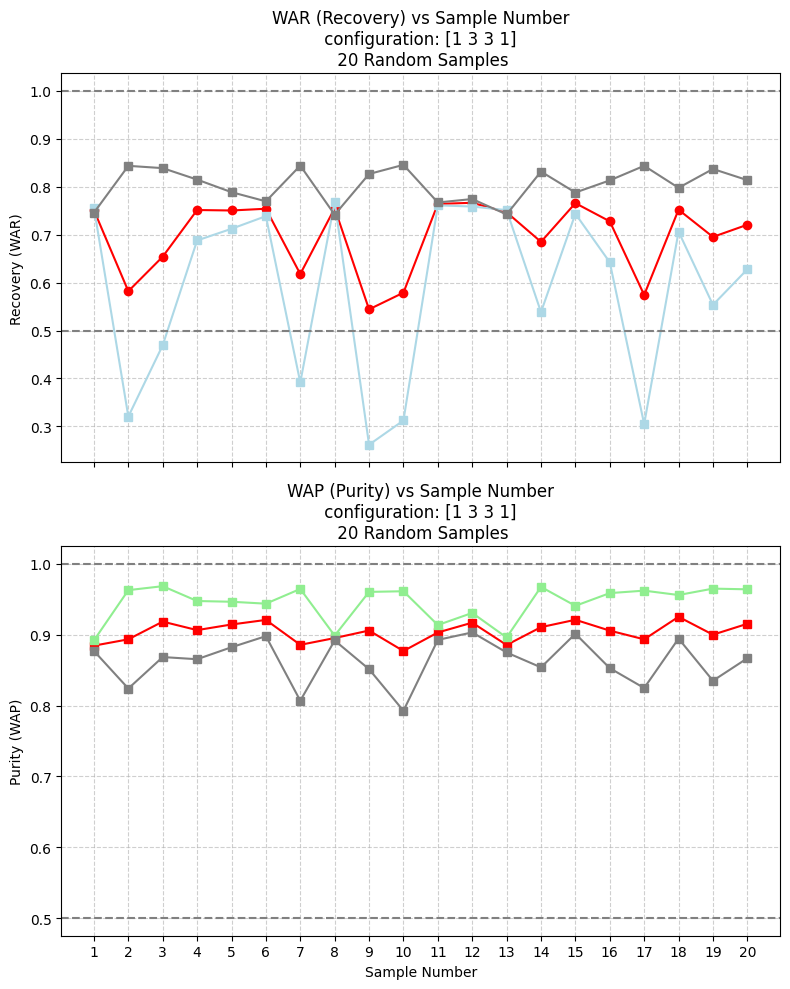

In [234]:
import numpy as np
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays and flatten
samples = np.arange(1, len(train_obj) + 1)  # Sample indices
WAR = train_con.numpy().flatten()  # Recovery values
WAP = train_obj.numpy().flatten()  # Purity values

# Create two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), sharex=True)

# Plot WAR (Recovery)
axes[0].plot(samples, WAR, 'o-', label="Weighted Average Recovery (WAR)", color='red')
axes[0].plot(samples, Rec[:,0], 's-', label="Glu Raff Recovery", color='lightblue')
axes[0].plot(samples, Rec[:,1], 's-', label="Fru Ext Recovery", color='grey')
axes[0].set_ylabel("Recovery (WAR)")
axes[0].axhline(y=0.5, color='gray', linestyle='--', label="Threshold = 0.5")  # Horizontal line at 0.5
axes[0].axhline(y=1.0, color='gray', linestyle='--')  # Horizontal line at 0.5
axes[0].set_title(f"WAR (Recovery) vs Sample Number\n configuration: {zone_config} \n {20} Random Samples")
axes[0].grid(True, linestyle='--', alpha=0.6)
# axes[0].legend()

# Plot WAP (Purity)
axes[1].plot(samples, WAP, 's-', label="Weighted Average Purity (WAP)", color='red')
axes[1].plot(samples, Pur[:,0], 's-', label="Glu Raff Purity", color='lightgreen')
axes[1].plot(samples, Pur[:,1], 's-', label="Fru Ext Purity", color='grey')
axes[1].axhline(y=0.5, color='gray', linestyle='--', label="Threshold = 0.5")  # Horizontal line at 0.5
axes[1].axhline(y=1.0, color='gray', linestyle='--')  # Horizontal line at 0.5
axes[1].set_xlabel("Sample Number")
axes[1].set_ylabel(f"Purity (WAP)")
axes[1].set_title(f"WAP (Purity) vs Sample Number\n configuration: {zone_config} \n {20} Random Samples")
axes[1].grid(True, linestyle='--', alpha=0.6)
# axes[1].legend()

# Adjust layout
plt.tight_layout()
axes[1].set_xticks(samples)  # Ensures only integer sample numbers appear
plt.show()


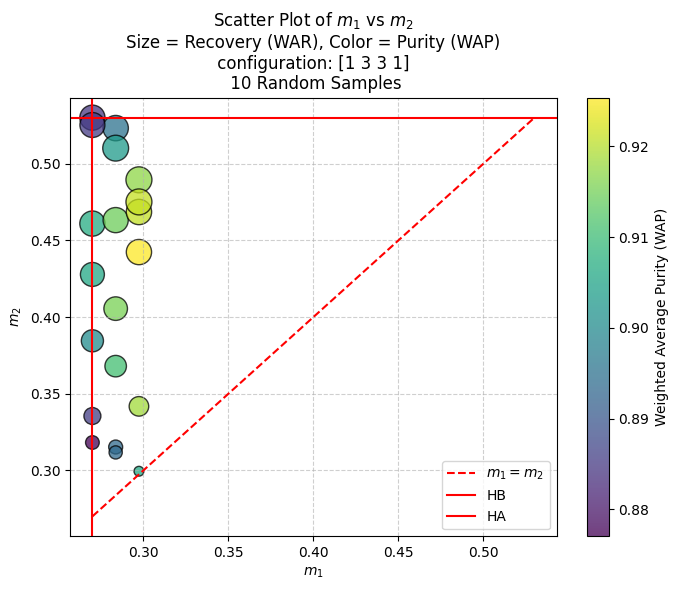

In [210]:
import numpy as np
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays and flatten
m1, m2 = train_x[:, 0].numpy(), train_x[:, 1].numpy()
WAR = train_con.numpy().flatten()  # Recovery (circle size)
WAP = train_obj.numpy().flatten()  # Purity (colorbar)

# Normalize WAR for bubble size
WAR_size = (WAR - WAR.min()) / (WAR.max() - WAR.min()) * 300 + 50  # Scale for better visibility

fig, ax = plt.subplots(figsize=(7, 6))

# Scatter plot: size = WAR, color = WAP
sc = ax.scatter(m1, m2, s=WAR_size, c=WAP, cmap='viridis', edgecolors='k', alpha=0.75)

# Add diagonal line (m1 = m2)
ax.plot([m_min, m_max], [m_min, m_max], 'r--', label='$m_1 = m_2$')

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Labels and title
ax.set_xlabel("$m_1$")
ax.set_ylabel("$m_2$")
ax.set_title(f"Scatter Plot of $m_1$ vs $m_2$\nSize = Recovery (WAR), Color = Purity (WAP)\n configuration: {zone_config} \n {10} Random Samples")
ax.axvline(x=m_min, color='r', linestyle='-', label="HB")
# - - - - - - -
ax.axhline(y=m_max, color='r', linestyle='-', label="HA")
# Add colorbar for WAP
cbar = plt.colorbar(sc)
cbar.set_label("Weighted Average Purity (WAP)")
# Set axis limits if specified

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


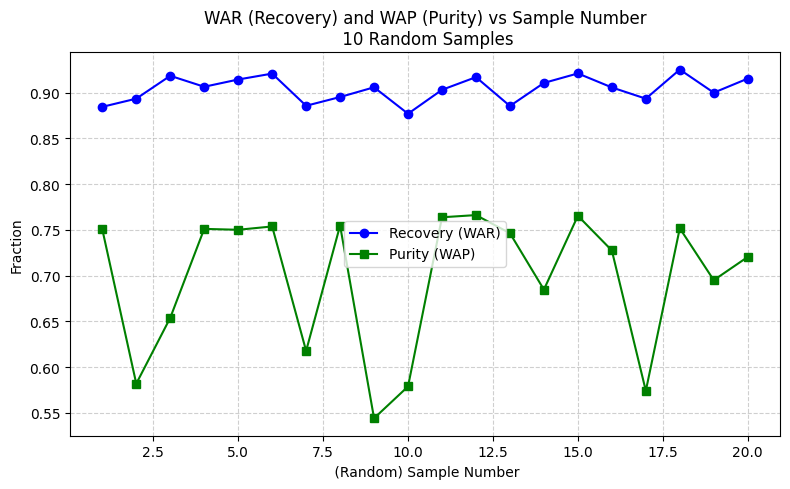

In [235]:
import numpy as np
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays and flatten
samples = np.arange(1,len(train_obj)+1)  # Sample indices
WAR = train_obj.numpy().flatten()  # Recovery values
WAP = train_con.numpy().flatten()  # Purity values

fig, ax = plt.subplots(figsize=(8, 5))

# Plot WAR (Recovery)
ax.plot(samples, WAR, 'o-', label="Recovery (WAR)", color='blue')

# Plot WAP (Purity)
ax.plot(samples, WAP, 's-', label="Purity (WAP)", color='green')

# Labels and title
ax.set_xlabel(" (Random) Sample Number")
ax.set_ylabel("Fraction")
ax.set_title("WAR (Recovery) and WAP (Purity) vs Sample Number\n 10 Random Samples")

# Grid for readability
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
ax.legend()

plt.tight_layout()
plt.show()


**Define a construct to extract the objective and constraint from the GP**

The methods below take the outputs of the GP and return the objective and the constraint. In general, these can be any Callable, but here we simply need to index the correct output.

In [ ]:
from botorch.acquisition.objective import GenericMCObjective

def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    '''
    Z = Torch tensor that is the output of ????
    '''
    return Z[..., 0]


def constraint_callable(Z):
    return Z[..., 1]


objective = GenericMCObjective(objective=obj_callable)


# **Define a helper function that performs the essential BO step**

The helper function below takes an acquisition function as an argument, optimizes it, and returns the batch [x1,x2,..xq], where x E R^6 - along with the observed function values.

For this example, we'll use a small batch of q=3.

The function optimize_acqf optimizes the
 points jointly. A simple initialization heuristic is used to select the 10 restart initial locations from a set of 50 random points.

In [ ]:
from botorch.optim import optimize_acqf
# bounds = [m2, m3]
bounds = torch.tensor([
    [m_min, m_min],  # Lower bounds
    [m_max, m_max]   # Upper bounds
], device=device, dtype=dtype)

BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    # ensure the
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE, # how many candidate points to recommennd
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    # new_x = [QD, QX, t_index]
    new_x = candidates.detach()

    print(f'Getting WAP and WAR Performance:')
    exact_WAR, exact_WAP, feasibility_weights = weighted_obj(new_x, constraint_threshold)

    exact_obj = exact_WAR * feasibility_weights
    exact_con = exact_WAP


    exact_obj = torch.tensor(np.array([exact_obj]), dtype=torch.float32, device=device)
    exact_con = torch.tensor(np.array([exact_con]), dtype=torch.float32, device=device)


    new_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    new_con = exact_con + NOISE_SE * torch.randn_like(exact_con)

    return new_x, new_obj, new_con


def update_random_observations(best_random):
    """Simulates a random policy by taking a the current list of best values observed randomly,
    drawing a new random point, observing its value, and updating the list.
    """
    rand_x = torch.rand(BATCH_SIZE, 5)
    next_random_best = weighted_obj(rand_x).max().item()
    best_random.append(max(best_random[-1], next_random_best))
    return best_random

**Perform Bayesian Optimization loop with qLogNEI**

The Bayesian optimization "loop" for a batch size of, q, simply iterates the following steps:

1. given a surrogate model, choose a batch of points [x1,x2,..,xq]
2. observe f(x) for each, x, in the batch
3. update the surrogate model.

Just for illustration purposes, we run three trials each of which do N_BATCH=20 rounds of optimization. The acquisition function is approximated using MC_SAMPLES=256 samples.

In [ ]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

n_initial = [10,10,10] # initial points per trial
N_TRIALS = len(n_initial) if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 256 if not SMOKE_TEST else 32
verbose = False

best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_observed_nei, best_random = [], [], []

    # call helper functions to generate initial training data and initialize model
    print(f'\nGenerating {n_initial[trial-1]} random initial points for trial {trial}:')
    print(f'----------------------------------------')
    (train_x_ei,
    train_obj_ei,
    train_con_ei,
    WAR,
    WAP,
    feasibility_weights,
    best_observed_value_ei

    ) = generate_initial_data(constraint_threshold=0.75, n=n_initial[trial-1], t_index_min = t_index_min)
    print(f'train_obj_ei: {train_obj_ei}')
    print(f'train_obj_ei-shape: {np.shape(train_obj_ei)}')
    print(f'train_con_ei: {train_con_ei}')
    print(f'train_con_ei-shape: {np.shape(train_con_ei)}')
    # Fit GPs to inital data
    print(f'Fitting GPs to inital data. . .')
    print(f'-------------------------------')
    mll_ei, model_ei = initialize_model(train_x_ei, train_obj_ei, train_con_ei)

    train_x_nei, train_obj_nei, train_con_nei = train_x_ei, train_obj_ei, train_con_ei
    best_observed_value_nei = best_observed_value_ei
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei, train_con_nei)

    best_observed_ei.append(best_observed_value_ei)
    best_observed_nei.append(best_observed_value_nei)
    best_random.append(best_observed_value_ei)

    # run N_BATCH rounds of BayesOpt after the initial random batch

    for iteration in range(1, N_BATCH + 1):

        t0 = time.monotonic()

        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_nei)

        # define the qEI and qNEI acquisition modules using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

        # for best_f, we use the best observed noisy values as an approximation
        qLogEI = qLogExpectedImprovement(
            model=model_ei,
            best_f=(train_obj_ei * (train_con_ei <= 0).to(train_obj_ei)).max(),
            sampler=qmc_sampler,
            objective=objective,
            constraints=[constraint_callable],
        )

        qLogNEI = qLogNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
            objective=objective,
            constraints=[constraint_callable],
        )

        # optimize and get new observation
        print(f'maximizing EI:')
        print(f'-----------------')
        #as advised by ei:
        new_x_ei, new_obj_ei, new_con_ei = optimize_acqf_and_get_observation(qLogEI)
        print(f'maximizing NEI:')
        print(f'-----------------')
        #as advised by nei:
        # new_x_nei, new_obj_nei, new_con_nei = optimize_acqf_and_get_observation(qLogNEI)

        # update training points
        # for ei:
        new_obj_ei = new_obj_ei.T  # Convert new from (1,n) to (n,1)
        new_con_ei = new_con_ei.T

        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei], dim=0)
        train_con_ei = torch.cat([train_con_ei, new_con_ei], dim=0)

        # # for nei:
        # new_obj_nei = new_obj_nei.T  # Convert new from (1,n) to (n,1)
        # new_con_nei = new_con_nei.T

        # train_x_nei = torch.cat([train_x_nei, new_x_nei])
        # train_obj_nei = torch.cat([train_obj_nei, new_obj_nei], dim=0)
        # train_con_nei = torch.cat([train_con_nei, new_con_nei], dim=0)


        # update progress
        # best_random = update_random_observations(best_random)
        best_value_ei = train_obj_ei.max().item()
        best_value_nei = train_obj_nei.max().item()
        best_observed_ei.append(best_value_ei)
        best_observed_nei.append(best_value_nei)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei,
            train_obj_ei,
            train_con_ei,
            model_ei.state_dict(),
        )
        # mll_nei, model_nei = initialize_model(
        #     train_x_nei,
        #     train_obj_nei,
        #     train_con_nei,
        #     model_nei.state_dict(),
        # )

        t1 = time.monotonic()

        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI, qNEI) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}, {best_value_nei:>4.2f}), "
                f"time = {t1-t0:>4.2f}.",
                end="",
            )
        else:
            print(".", end="")

    best_observed_all_ei.append(best_observed_ei)
    best_observed_all_nei.append(best_observed_nei)
    best_random_all.append(best_random)


Trial  1 of 3 
Generating 10 random initial points for trial 1:
----------------------------------------


KeyboardInterrupt: 

Plot the results¶



The plot below shows the best objective value observed at each step of the optimization for each of the algorithms. The confidence intervals represent the variance at that step in the optimization across the trial runs. The variance across optimization runs is quite high, so in order to get a better estimate of the average performance one would have to run a much larger number of trials N_TRIALS (we avoid this here to limit the runtime of this tutorial).

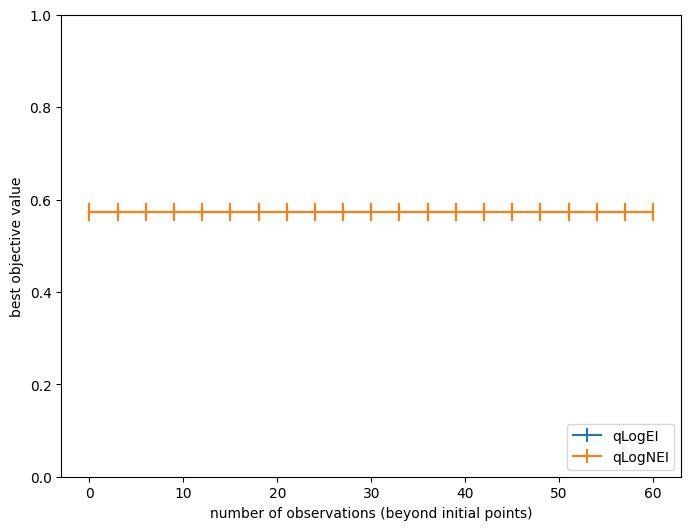

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)


GLOBAL_MAXIMUM = neg_hartmann6.optimal_value


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_all_ei)
y_nei = np.asarray(best_observed_all_nei)
y_rnd = np.asarray(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="qLogEI", linewidth=1.5)
ax.errorbar(iters, y_nei.mean(axis=0), yerr=ci(y_nei), label="qLogNEI", linewidth=1.5)
# plt.plot(
#     [0, N_BATCH * BATCH_SIZE],
#     [GLOBAL_MAXIMUM] * 2,
#     "k",
#     label="true best feasible objective",
#     linewidth=2,
# )
ax.set_ylim(top=1,bottom=0)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")